# **Лабораторная работа №6**
## **Случайный лес (Random Forest)**
**Цель работы**:
1.   Освоит метод Random Forest (Случайный лес) - алгоритм машинного обучения, относящийся к классу ансамблевых методов.
2.   Создать и обучить модель Random Forest.
3.   Оценить эффективность алгоритма на практическом примере.
4.   Подобрать гиперпараметры дял улучшения модели.


В этой работе мы используем набор данных о прогнозирование рака (бинарная классификация).



In [59]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

# Для воспроисводимости результатов
np.random.seed(42)

## 2. Загрузка и первичный анализ данных

In [60]:
# Загружаем набор данных о винах (бинарная классификация)
data = pd.read_csv("cancer_data.csv")
data.head()

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
0,58,1,16.085313,0,1,8.146251,4.148219,1,1
1,71,0,30.828784,0,1,9.361630,3.519683,0,0
2,48,1,38.785084,0,2,5.135179,4.728368,0,1
3,34,0,30.040296,0,0,9.502792,2.044636,0,0
4,62,1,35.479721,0,0,5.356890,3.309849,0,1


In [61]:
data.describe()

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,50.320000,0.490667,27.513321,0.269333,0.508667,4.897929,2.417987,0.144000,0.371333
std,17.640968,0.500080,7.230012,0.443761,0.678895,2.866162,1.419318,0.351207,0.483322
min,20.000000,0.000000,15.000291,0.000000,0.000000,0.002410,0.001215,0.000000,0.000000
25%,35.000000,0.000000,21.483134,0.000000,0.000000,2.434609,1.210598,0.000000,0.000000
50%,51.000000,0.000000,27.598494,0.000000,0.000000,4.834316,2.382971,0.000000,0.000000
75%,66.000000,1.000000,33.850837,1.000000,1.000000,7.409896,3.585624,0.000000,1.000000
max,80.000000,1.000000,39.958688,1.000000,2.000000,9.994607,4.987115,1.000000,1.000000


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1500 non-null   int64  
 1   Gender            1500 non-null   int64  
 2   BMI               1500 non-null   float64
 3   Smoking           1500 non-null   int64  
 4   GeneticRisk       1500 non-null   int64  
 5   PhysicalActivity  1500 non-null   float64
 6   AlcoholIntake     1500 non-null   float64
 7   CancerHistory     1500 non-null   int64  
 8   Diagnosis         1500 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 105.6 KB


## 3. Исключаем невлияющие категориальные признаки

In [66]:
data_copy = data.copy()
cat_feat = ['Gender', 'PhysicalActivity']
data_copy.drop(cat_feat, axis = 1, inplace = True)
data_copy.head()

,Age,BMI,Smoking,GeneticRisk,AlcoholIntake,CancerHistory,Diagnosis
0,58,16.085313,0,1,4.148219,1,1
1,71,30.828784,0,1,3.519683,0,0
2,48,38.785084,0,2,4.728368,0,1
3,34,30.040296,0,0,2.044636,0,0
4,62,35.479721,0,0,3.309849,0,1


In [67]:
# проверяем на пропущенные значения
data_copy.isnull().sum()

,0
Age,0
BMI,0
Smoking,0
GeneticRisk,0
AlcoholIntake,0
CancerHistory,0
Diagnosis,0


## 4. Разделяем данные на признаки и целевую переменную

In [73]:
# Разделяем данные на обучающую и тестовую выборки (70/30)
y = data_copy['Diagnosis']
X = data_copy.drop('Diagnosis', axis = 1)
X

,Age,BMI,Smoking,GeneticRisk,AlcoholIntake,CancerHistory
0,58,16.085313,0,1,4.148219,1
1,71,30.828784,0,1,3.519683,0
2,48,38.785084,0,2,4.728368,0
3,34,30.040296,0,0,2.044636,0
4,62,35.479721,0,0,3.309849,0
...,...,...,...,...,...,...
1495,62,25.090025,0,0,1.284158,0
1496,31,33.447125,0,1,2.280636,1
1497,63,32.613861,1,1,0.150101,0
1498,55,25.568216,0,0,1.986138,1


## 5. Применяем операцию нормализации для численной устойчивости

In [71]:
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)
X

array([[ 0.43549546, -1.58116185, -0.60713519,  0.72396612,  1.21946526,
         2.43812314],
       [ 1.17266226,  0.45872244, -0.60713519,  0.72396612,  0.77647404,
        -0.41015156],
       [-0.13155592,  1.55954393, -0.60713519,  2.19743855,  1.62835335,
        -0.41015156],
       ...,
       [ 0.71902115,  0.70570289,  1.64707962,  0.72396612, -1.59840354,
        -0.41015156],
       [ 0.26538005, -0.26912183, -0.60713519, -0.74950631, -0.30436716,
         2.43812314],
       [ 0.9458417 , -0.5327102 , -0.60713519, -0.74950631,  0.30913374,
         2.43812314]])

## 6. Разделение данных на обучающую и тестовую выборки

In [41]:
# Разделяем данные на обучающую и тестовую выборки (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Обучающая выборка: {X_train.shape[0]} samples")
print(f"Тестовая выборка: {X_test.shape[0]} samples")

Обучающая выборка: 1050 samples
Тестовая выборка: 450 samples


## 7. Создание и обучение модели Random Forest

In [42]:
# Создаем модель Random Forest
# n_estimators - количество деревбев в лесу
# random_state - для воспроизводимости результатов
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучаем модель на обучающих данных
rf_model.fit(X_train, y_train)

print("Модель Random Forest обучена!")

Модель Random Forest обучена!


## 8. Прогнозирование и оценка модели

In [43]:
# Делаем прогнозы на тестовой выборке
y_pred = rf_model.predict(X_test)

# Оцениваем точность модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели на тестовой выборке: {accuracy:.4f}")

Точность модели на тестовой выборке: 0.8267


In [44]:
# Выводим подробный отчет по классификации
print("\n" + "="*50)
print("Отчет по классификации:")
print("="*50)
print(classification_report(y_test, y_pred, target_names=target_names))


Отчет по классификации:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       275
           1       0.80      0.74      0.77       175

    accuracy                           0.83       450
   macro avg       0.82      0.81      0.82       450
weighted avg       0.83      0.83      0.83       450



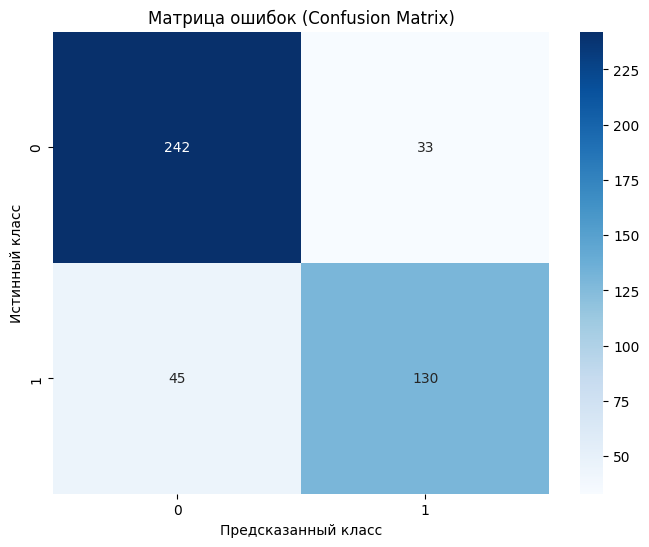

In [45]:
# Строим матрицу ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Матрица ошибок (Confusion Matrix)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

## 9. Анализ важности признаков

Одна из ключевых особенностей Random Forest - возможность оценить важность каждого признака.

In [74]:
# Важность признаков на основе среднего уменьшения неоднородности (Gini Importance)
feature_importances = rf_model.feature_importances_
features_df = pd.DataFrame({"feature": X.columns, "importance": feature_importances})
features_df = features_df.sort_values("importance", ascending=False)

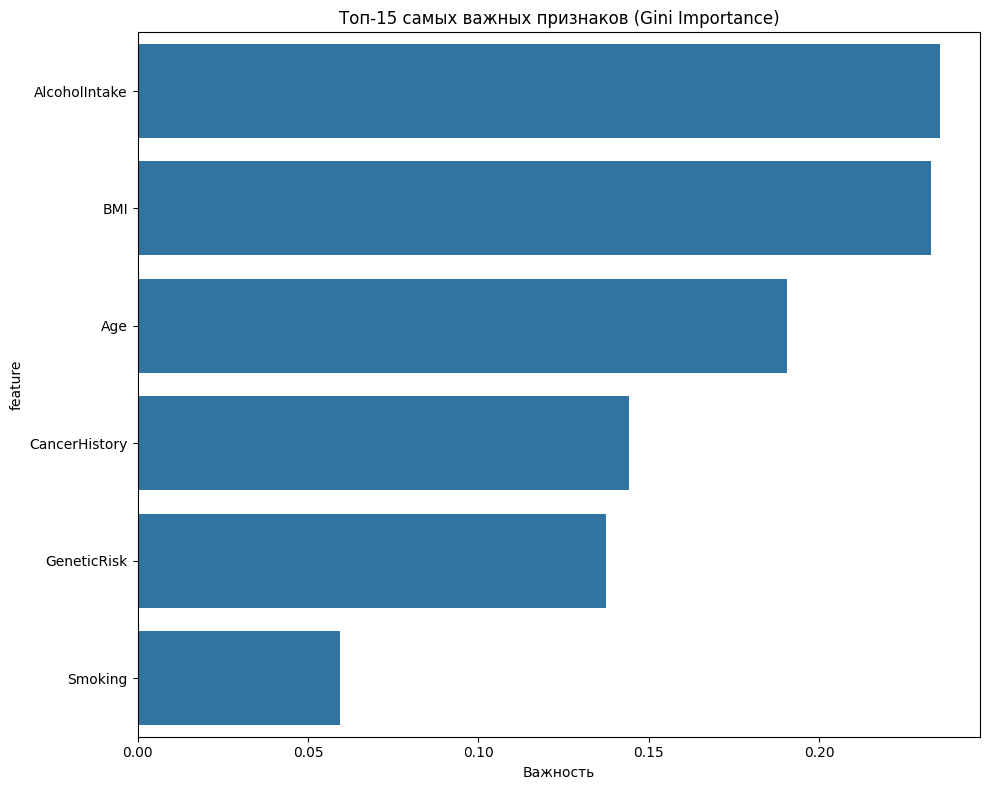

In [75]:
# Визуализация важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=features_df.head(15)) # Покажем топ-15 признаков
plt.title("Топ-15 самых важных признаков (Gini Importance)")
plt.xlabel("Важность")
plt.tight_layout()
plt.show()

In [76]:
# Вывод таблицы с важность признаков
print("Топ-10 самых важных признаков:")
print(features_df.head(10))

Топ-10 самых важных признаков:
         feature  importance
4  AlcoholIntake    0.235412
1            BMI    0.232798
0            Age    0.190656
5  CancerHistory    0.144164
3    GeneticRisk    0.137445
2        Smoking    0.059524


## 10. Подбор гиперпараметров

Для улучшения модели можно подобрать оптимальные гиперпараметры с помощью GridSearchCV

In [77]:
from sklearn.model_selection import GridSearchCV

# Определяем сетку параметров для перебора
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

In [78]:
# Создаем модель для поиска
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1)

# Запускаем поиск (может занять некоторое время)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [80]:
# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность при кросс-валидации: {:.4f}".format(grid_search.best_score_))

Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Лучшая точность при кросс-валидации: 0.8400


In [81]:
# Оцениваем лучшую модель на тестовых данных
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Точность улучшенной модели на тестовой выборке: {best_accuracy:.4f}")

Точность улучшенной модели на тестовой выборке: 0.8511
